In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PROJECT II Deep Learning and Its Applications/Dataset/Tweets.csv',delimiter=',',encoding='latin-1')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

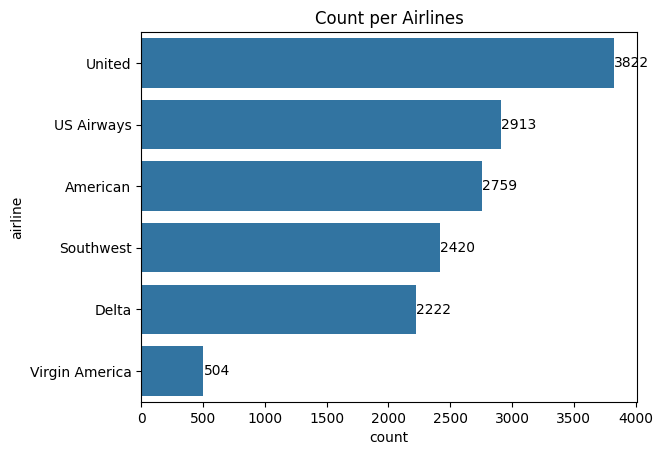

In [ ]:
ax = sns.countplot(data = df, y = 'airline',
                   order = df.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)

plt.show()

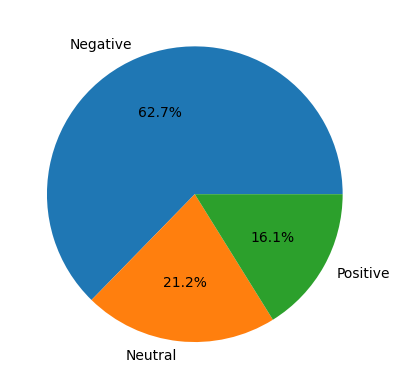

In [ ]:
label=['Negative','Neutral','Positive']
plt.pie(df.groupby('airline_sentiment')['airline_sentiment'].count(),autopct="%.1f%%",labels=label)
plt.show()

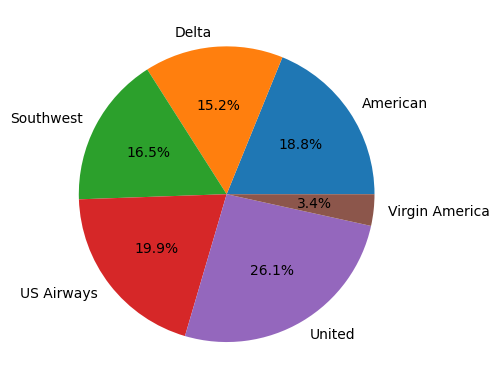

In [ ]:
label=['American', 'Delta', 'Southwest', 'US Airways', 'United',
       'Virgin America']
plt.pie(df.groupby('airline')['airline_sentiment'].count(),autopct="%.1f%%",labels=label)
plt.show()

## What is the worst negative reason ?

<Axes: ylabel='negativereason'>

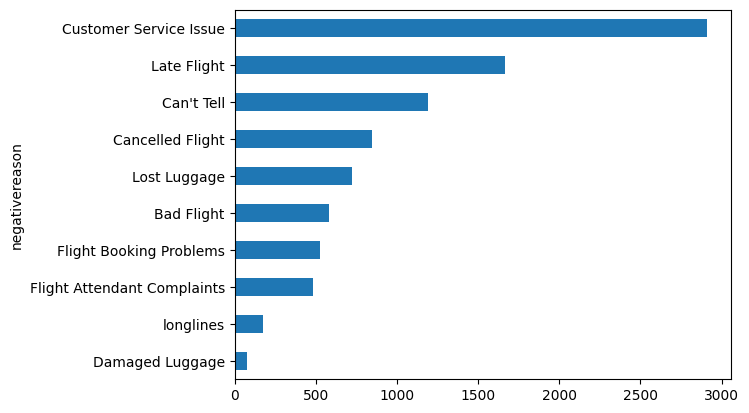

In [ ]:
df.groupby('negativereason')['negativereason'].count().sort_values(ascending=True).plot.barh()

## Ratio of 'Negative', 'Positive' and 'Neutral' by airplanes

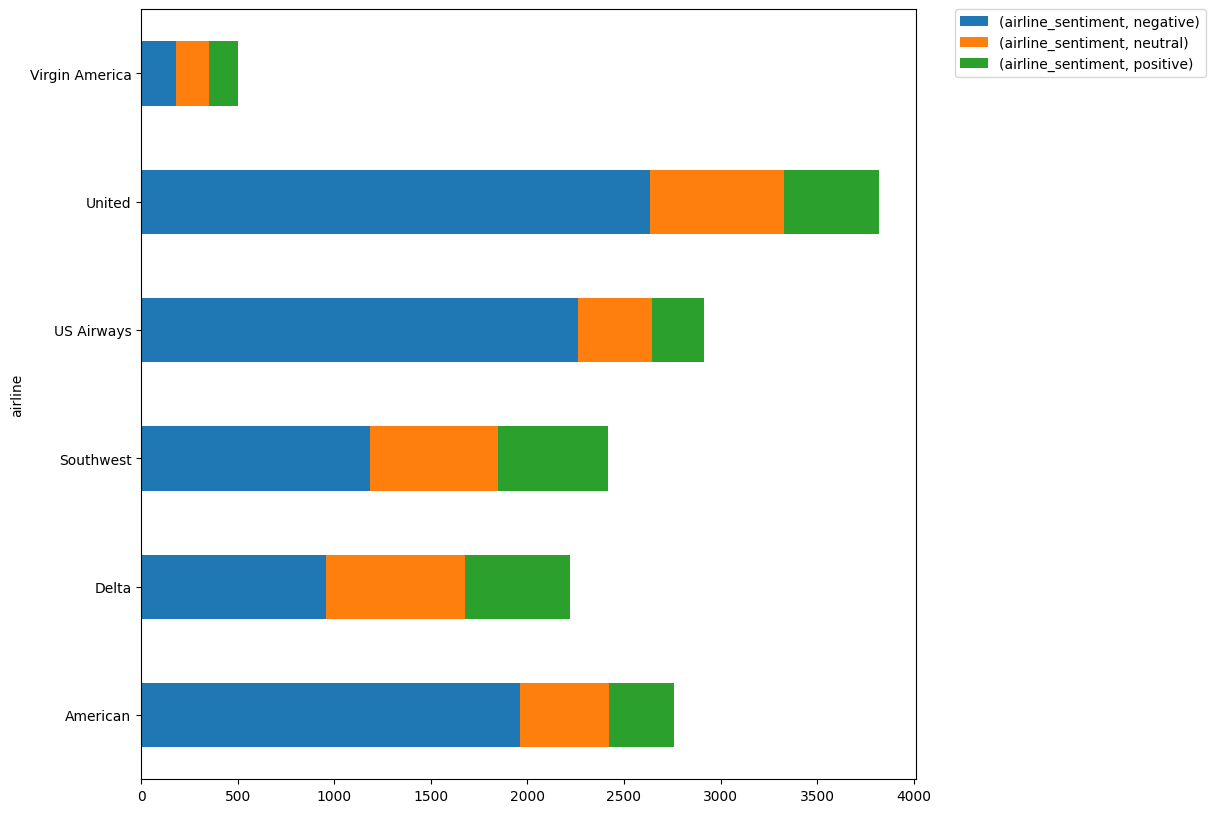

In [ ]:
pd.DataFrame(df.groupby('airline')['airline_sentiment'].value_counts()).unstack().plot.barh(figsize=(10,10),stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

## Kernel distribution of number of words by 'Negative', 'Positive' and 'Neutral'

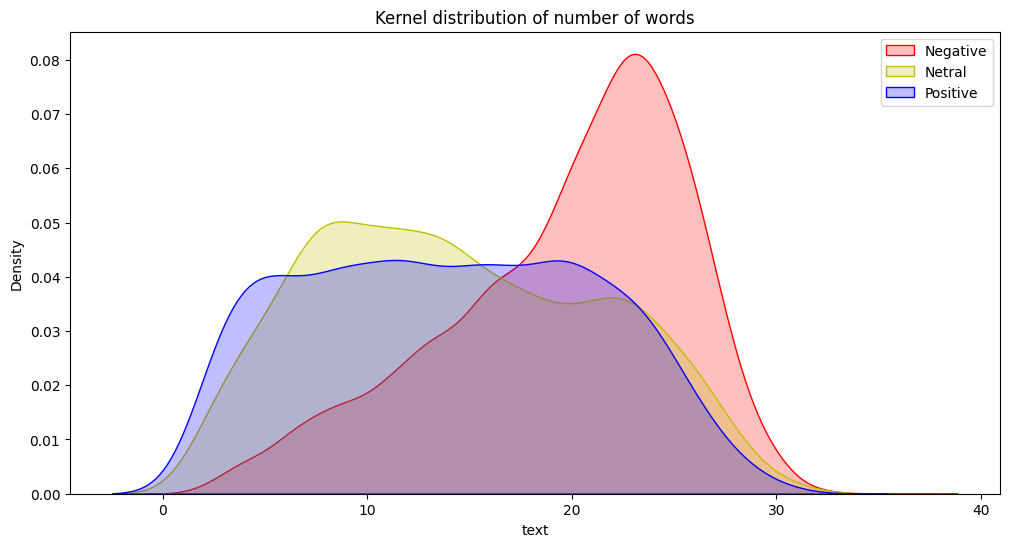

In [ ]:
num_neg = df[df['airline_sentiment']=='negative']['text'].apply(lambda x: len(x.split()))
num_neu = df[df['airline_sentiment']=='neutral']['text'].apply(lambda x: len(x.split()))
num_pos = df[df['airline_sentiment']=='positive']['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.kdeplot(num_neg, shade=True, color = 'r').set_title('Kernel distribution of number of words')
sns.kdeplot(num_neu, shade=True, color = 'y')
sns.kdeplot(num_pos, shade=True, color = 'b')

plt.legend(labels=['Negative', 'Netral','Positive'])

In [ ]:
!pip install nltk

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways',
         'virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway',
         'flight', 'airline', 'airlines']

# In 'Twitter Sentiment Analysis - EDA and ML/DL', the name of airlines are not relevant to the sentiment analysis and added to the list of stop words.
# So I followed it.
def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [ ]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
print(" ".join(df.final_text[10000]))

dhepburn said 

plus youve added commercials experience tacky 

trying add boy prince ressie sf thursday lax httptcogsbjcgm 

put bag plane seattle waiting line talk someone bag status matter 

waiting day atl since cancelled flightled standby told seats group shows late gets phl


## Text Cleaning

In [ ]:
def remove_stopwords(text):
    "removes stopwords"
    # customize stopwords
    my_stopwords = stopwords.words("english")
    my_stopwords.remove("not")
    # remove stopwords
    filtered_words = [word for word in text if word not in my_stopwords]
    return filtered_words

def remove_punctuation(text):
    "removes punctutation"
    my_punct = string.punctuation
    my_punct += "“”’" # add unusual apostrophes
    no_punct = [w for w in text if w not in my_punct]
    return no_punct

def remove_numbers(text):
    "removes strings containing only digits"
    reduced = re.sub(r'\b[0-9]+\b\s*', '', text)
    return reduced

def remove_signs(text, sign):
    "removes a particular sign"
    try:
        reduced = [w for w in text if sign not in w]
        return reduced
    except Exception as e:
        print(e)
        return text

def remove_links(text):
    "removes links"
    reduced = re.sub(r'http\S+', '', text)
    return reduced

In [ ]:
def clean_text(inp_text):
    """
        This function is a pipeline for text preprocessing
        It consists of following steps:
            - converting text to lowercase
            - removing words containing only digits
            - removing links
            - removing stopwords
            - removing punctuation
            - removing mentions and hashtags
    """
    #lowercase
    text = inp_text.lower()
    # remove only number words
    text = remove_numbers(text)
    # remove links
    text = remove_links(text)
    # divide input sentence into words
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)
    # remove stopwords
    text = remove_stopwords(text)
    # remove punctuation
    text = remove_punctuation(text)
    # remove mentions
    text = remove_signs(text, "@")
    # remove hashtags
    text = remove_signs(text, "#")
    # join a list of words into a sentence
    filtered_sentence = (" ").join(text)
    return filtered_sentence

## Finalize text to classify

In [ ]:
for i in range(len(df)):
    df['final_text'][i] = " ".join(df['final_text'][i])

In [ ]:
df['final_text'][:3]

0                                    dhepburn said
1    plus youve added commercials experience tacky
2     didnt today must mean need take another trip
Name: final_text, dtype: object

In [ ]:
def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0

df.airline_sentiment = df.airline_sentiment.apply(lambda x : convert_Sentiment(x))

In [ ]:
X = df.final_text
y = df.airline_sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.2, random_state = 4)

In [ ]:
def tfidf(words):
    tfidf_vectorizer = TfidfVectorizer()
    data_feature = tfidf_vectorizer.fit_transform(words)
    return data_feature, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.tolist())

In [ ]:
X_train_tfidf.shape

(11712, 12616)

In [ ]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 @VirginAmerica What @dhepburn said. 

After Tokenization & Padding 
 [ 81  62 226   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [ ]:
y = pd.get_dummies(df.airline_sentiment)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (8198, 100) (8198, 3)
Validation Set: (3514, 100) (3514, 3)
Test Set:       (2928, 100) (2928, 3)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [ ]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
129/129 [==============================] - 27s 147ms/step - loss: 0.0367 - accuracy: 0.9896 - val_loss: 1.5633 - val_accuracy: 0.7692
Epoch 2/50
129/129 [==============================] - 11s 88ms/step - loss: 0.0260 - accuracy: 0.9932 - val_loss: 1.6321 - val_accuracy: 0.7629
Epoch 3/50
129/129 [==============================] - 7s 57ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 1.6161 - val_accuracy: 0.7664
Epoch 4/50
129/129 [==============================] - 8s 58ms/step - loss: 0.0248 - accuracy: 0.9927 - val_loss: 1.5704 - val_accuracy: 0.7587
Epoch 5/50
129/129 [==============================] - 7s 52ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 1.5729 - val_accuracy: 0.7763
Epoch 6/50
129/129 [==============================] - 8s 64ms/step - loss: 0.0301 - accuracy: 0.9916 - val_loss: 1.5603 - val_accuracy: 0.7709
Epoch 7/50
129/129 [==============================] - 7s 54ms/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 1.6456 - val_accuracy: 0.7

In [ ]:
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.7503


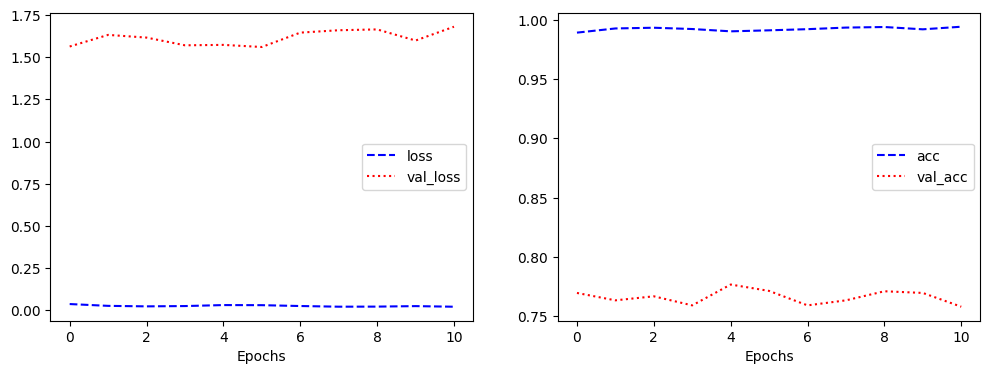

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

92/92 [==============================] - 1s 15ms/step


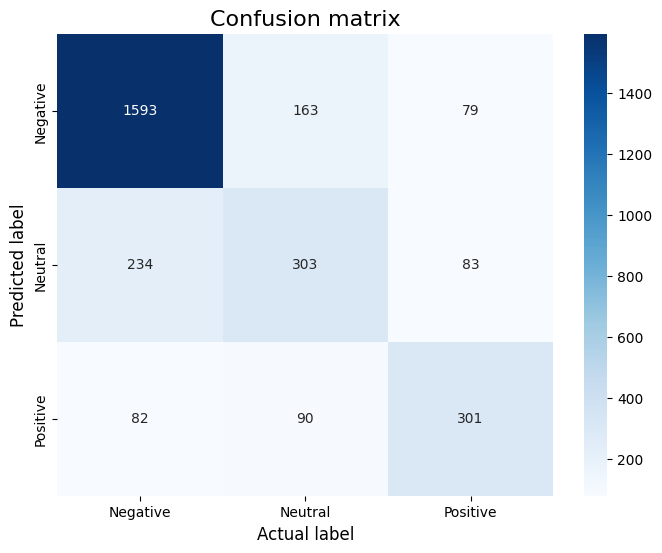

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_tst, y_tst)